In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
from pyiron import Project

In [4]:
from pyiron.atomistics.structure.atoms import Atoms

In [5]:
pr = Project("elastic")

In [6]:
potential = 'Fe_C_Hepburn_Ackland_eam'

In [7]:
structure = pr.create_ase_bulk("Fe", cubic=True)

# Class definition

In [8]:
# coding: utf-8
# Copyright (c) Max-Planck-Institut für Eisenforschung GmbH - Computational Materials Design (CM) Department
# Distributed under the terms of "New BSD License", see the LICENSE file.

from collections import OrderedDict

import numpy as np
import spglib
import scipy.constants
from pyiron.atomistics.master.parallel import AtomisticParallelMaster
from pyiron.base.master.parallel import JobGenerator

__author__ = "Yury Lysogorskiy"
__copyright__ = "Copyright 2020, Max-Planck-Institut für Eisenforschung GmbH - Computational Materials Design (CM) Department"
__version__ = "1.0"
__maintainer__ = "Jan Janssen"
__email__ = "janssen@mpie.de"
__status__ = "development"
__date__ = "Sep 1, 2017"


def find_symmetry_group_number(struct):
    dataset = spglib.get_symmetry_dataset(struct)
    SGN = dataset["number"]
    return SGN


# Ref. Com. Phys. Comm. 184 (2013) 1861-1873
# and ElaStic source code
# for more details
Ls_Dic = {
    '01': [1., 1., 1., 0., 0., 0.],
    '02': [1., 0., 0., 0., 0., 0.],
    '03': [0., 1., 0., 0., 0., 0.],
    '04': [0., 0., 1., 0., 0., 0.],
    '05': [0., 0., 0., 2., 0., 0.],
    '06': [0., 0., 0., 0., 2., 0.],
    '07': [0., 0., 0., 0., 0., 2.],
    '08': [1., 1., 0., 0., 0., 0.],
    '09': [1., 0., 1., 0., 0., 0.],
    '10': [1., 0., 0., 2., 0., 0.],
    '11': [1., 0., 0., 0., 2., 0.],
    '12': [1., 0., 0., 0., 0., 2.],
    '13': [0., 1., 1., 0., 0., 0.],
    '14': [0., 1., 0., 2., 0., 0.],
    '15': [0., 1., 0., 0., 2., 0.],
    '16': [0., 1., 0., 0., 0., 2.],
    '17': [0., 0., 1., 2., 0., 0.],
    '18': [0., 0., 1., 0., 2., 0.],
    '19': [0., 0., 1., 0., 0., 2.],
    '20': [0., 0., 0., 2., 2., 0.],
    '21': [0., 0., 0., 2., 0., 2.],
    '22': [0., 0., 0., 0., 2., 2.],
    '23': [0., 0., 0., 2., 2., 2.],
    '24': [-1., .5, .5, 0., 0., 0.],
    '25': [.5, -1., .5, 0., 0., 0.],
    '26': [.5, .5, -1., 0., 0., 0.],
    '27': [1., -1., 0., 0., 0., 0.],
    '28': [1., -1., 0., 0., 0., 2.],
    '29': [0., 1., -1., 0., 0., 2.],
    '30': [.5, .5, -1., 0., 0., 2.],
    '31': [1., 0., 0., 2., 2., 0.],
    '32': [1., 1., -1., 0., 0., 0.],
    '33': [1., 1., 1., -2., -2., -2.],
    '34': [.5, .5, -1., 2., 2., 2.],
    '35': [0., 0., 0., 2., 2., 4.],
    '36': [1., 2., 3., 4., 5., 6.],
    '37': [-2., 1., 4., -3., 6., -5.],
    '38': [3., -5., -1., 6., 2., -4.],
    '39': [-4., -6., 5., 1., -3., 2.],
    '40': [5., 4., 6., -2., -1., -3.],
    '41': [-6., 3., -2., 5., -4., 1.]}


def get_symmetry_family_from_SGN(SGN):
    if 1 <= SGN <= 2:  # Triclinic
        LC = 'N'
    elif 3 <= SGN <= 15:  # Monoclinic
        LC = 'M'
    elif 16 <= SGN <= 74:  # Orthorhombic
        LC = 'O'
    elif 75 <= SGN <= 88:  # Tetragonal II
        LC = 'TII'
    elif 89 <= SGN <= 142:  # Tetragonal I
        LC = 'TI'
    elif 143 <= SGN <= 148:  # Rhombohedral II
        LC = 'RII'
    elif 149 <= SGN <= 167:  # Rhombohedral I
        LC = 'RI'
    elif 168 <= SGN <= 176:  # Hexagonal II
        LC = 'HII'
    elif 177 <= SGN <= 194:  # Hexagonal I
        LC = 'HI'
    elif 195 <= SGN <= 206:  # Cubic II
        LC = 'CII'
    elif 207 <= SGN <= 230:  # Cubic I
        LC = 'CI'
    else:
        raise ValueError('SGN should be 1 <= SGN <= 230')
    return LC


def get_LAG_Strain_List(LC):
    if LC == 'CI' or LC == 'CII':
        Lag_strain_list = ['01', '08', '23']
    elif LC == 'HI' or LC == 'HII':
        Lag_strain_list = ['01', '26', '04', '03', '17']
    elif LC == 'RI':
        Lag_strain_list = ['01', '08', '04', '02', '05', '10']
    elif LC == 'RII':
        Lag_strain_list = ['01', '08', '04', '02', '05', '10', '11']
    elif LC == 'TI':
        Lag_strain_list = ['01', '26', '27', '04', '05', '07']
    elif LC == 'TII':
        Lag_strain_list = ['01', '26', '27', '28', '04', '05', '07']
    elif LC == 'O':
        Lag_strain_list = ['01', '26', '25', '27', '03', '04', '05', '06', '07']
    elif LC == 'M':
        Lag_strain_list = ['01', '25', '24', '28', '29', '27', '20', '12', '03', '04', '05', '06', '07']
    else:  # (LC == 'N'):
        Lag_strain_list = ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
                           '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
    return Lag_strain_list


def get_C_from_A2(A2, LC):
    C = np.zeros((6, 6))

    # %!%!%--- Cubic structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%
    if LC == 'CI' or LC == 'CII':
        C[0, 0] = -2. * (A2[0] - 3. * A2[1]) / 3.
        C[1, 1] = C[0, 0]
        C[2, 2] = C[0, 0]
        C[3, 3] = A2[2] / 6.
        C[4, 4] = C[3, 3]
        C[5, 5] = C[3, 3]
        C[0, 1] = (2. * A2[0] - 3. * A2[1]) / 3.
        C[0, 2] = C[0, 1]
        C[1, 2] = C[0, 1]
    # --------------------------------------------------------------------------------------------------

    # %!%!%--- Hexagonal structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%
    if LC == 'HI' or LC == 'HII':
        C[0, 0] = 2. * A2[3]
        C[0, 1] = 2. / 3. * A2[0] + 4. / 3. * A2[1] - 2. * A2[2] - 2. * A2[3]
        C[0, 2] = 1. / 6. * A2[0] - 2. / 3. * A2[1] + 0.5 * A2[2]
        C[1, 1] = C[0, 0]
        C[1, 2] = C[0, 2]
        C[2, 2] = 2. * A2[2]
        C[3, 3] = -0.5 * A2[2] + 0.5 * A2[4]
        C[4, 4] = C[3, 3]
        C[5, 5] = .5 * (C[0, 0] - C[0, 1])
    # --------------------------------------------------------------------------------------------------

    # %!%!%--- Rhombohedral I structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!
    if LC == 'RI':
        C[0, 0] = 2. * A2[3]
        C[0, 1] = A2[1] - 2. * A2[3]
        C[0, 2] = .5 * (A2[0] - A2[1] - A2[2])
        C[0, 3] = .5 * (-A2[3] - A2[4] + A2[5])
        C[1, 1] = C[0, 0]
        C[1, 2] = C[0, 2]
        C[1, 3] = -C[0, 3]
        C[2, 2] = 2. * A2[2]
        C[3, 3] = .5 * A2[4]
        C[4, 4] = C[3, 3]
        C[4, 5] = C[0, 3]
        C[5, 5] = .5 * (C[0, 0] - C[0, 1])
    # --------------------------------------------------------------------------------------------------

    # %!%!%--- Rhombohedral II structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%
    if LC == 'RII':
        C[0, 0] = 2. * A2[3]
        C[0, 1] = A2[1] - 2. * A2[3]
        C[0, 2] = .5 * (A2[0] - A2[1] - A2[2])
        C[0, 3] = .5 * (-A2[3] - A2[4] + A2[5])
        C[0, 4] = .5 * (-A2[3] - A2[4] + A2[6])
        C[1, 1] = C[0, 0]
        C[1, 2] = C[0, 2]
        C[1, 3] = -C[0, 3]
        C[1, 4] = -C[0, 4]
        C[2, 2] = 2. * A2[2]
        C[3, 3] = .5 * A2[4]
        C[3, 5] = -C[0, 4]
        C[4, 4] = C[3, 3]
        C[4, 5] = C[0, 3]
        C[5, 5] = .5 * (C[0, 0] - C[0, 1])
    # --------------------------------------------------------------------------------------------------

    # %!%!%--- Tetragonal I structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!
    if LC == 'TI':
        C[0, 0] = (A2[0] + 2. * A2[1]) / 3. + .5 * A2[2] - A2[3]
        C[0, 1] = (A2[0] + 2. * A2[1]) / 3. - .5 * A2[2] - A2[3]
        C[0, 2] = A2[0] / 6. - 2. * A2[1] / 3. + .5 * A2[3]
        C[1, 1] = C[0, 0]
        C[1, 2] = C[0, 2]
        C[2, 2] = 2. * A2[3]
        C[3, 3] = .5 * A2[4]
        C[4, 4] = C[3, 3]
        C[5, 5] = .5 * A2[5]
    # --------------------------------------------------------------------------------------------------

    # %!%!%--- Tetragonal II structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%
    if LC == 'TII':
        C[0, 0] = (A2[0] + 2. * A2[1]) / 3. + .5 * A2[2] - A2[4]
        C[1, 1] = C[0, 0]
        C[0, 1] = (A2[0] + 2. * A2[1]) / 3. - .5 * A2[2] - A2[4]
        C[0, 2] = A2[0] / 6. - (2. / 3.) * A2[1] + .5 * A2[4]
        C[0, 5] = (-A2[2] + A2[3] - A2[6]) / 4.
        C[1, 2] = C[0, 2]
        C[1, 5] = -C[0, 5]
        C[2, 2] = 2. * A2[4]
        C[3, 3] = .5 * A2[5]
        C[4, 4] = C[3, 3]
        C[5, 5] = .5 * A2[6]
    # --------------------------------------------------------------------------------------------------

    # %!%!%--- Orthorhombic structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!
    if LC == 'O':
        C[0, 0] = 2. * A2[0] / 3. + 4. * A2[1] / 3. + A2[3] - 2. * A2[4] - 2. * A2[5]
        C[0, 1] = 1. * A2[0] / 3. + 2. * A2[1] / 3. - .5 * A2[3] - A2[5]
        C[0, 2] = 1. * A2[0] / 3. - 2. * A2[1] / 3. + 4. * A2[2] / 3. - .5 * A2[3] - A2[4]
        C[1, 1] = 2. * A2[4]
        C[1, 2] = -2. * A2[1] / 3. - 4. * A2[2] / 3. + .5 * A2[3] + A2[4] + A2[5]
        C[2, 2] = 2. * A2[5]
        C[3, 3] = .5 * A2[6]
        C[4, 4] = .5 * A2[7]
        C[5, 5] = .5 * A2[8]
    # --------------------------------------------------------------------------------------------------

    # %!%!%--- Monoclinic structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!
    if LC == 'M':
        C[0, 0] = 2. * A2[0] / 3. + 8. * (A2[1] + A2[2]) / 3. - 2. * (A2[5] + A2[8] + A2[9])
        C[0, 1] = A2[0] / 3. + 4. * (A2[1] + A2[2]) / 3. - 2. * A2[5] - A2[9]
        C[0, 2] = (A2[0] - 4. * A2[2]) / 3. + A2[5] - A2[8]
        C[0, 5] = -1. * A2[0] / 6. - 2. * (A2[1] + A2[2]) / 3. + .5 * (A2[5] + A2[7] + A2[8] + A2[9] - A2[12])
        C[1, 1] = 2. * A2[8]
        C[1, 2] = -4. * (2. * A2[1] + A2[2]) / 3. + 2. * A2[5] + A2[8] + A2[9] + A2[12]
        C[1, 5] = -1. * A2[0] / 6. - 2. * (A2[1] + A2[2]) / 3. - .5 * A2[3] + A2[5] + .5 * (A2[7] + A2[8] + A2[9])
        C[2, 2] = 2. * A2[9]
        C[2, 5] = -1. * A2[0] / 6. + 2. * A2[1] / 3. - .5 * (A2[3] + A2[4] - A2[7] - A2[8] - A2[9] - A2[12])
        C[3, 3] = .5 * A2[10]
        C[3, 4] = .25 * (A2[6] - A2[10] - A2[11])
        C[4, 4] = .5 * A2[11]
        C[5, 5] = .5 * A2[12]
    # --------------------------------------------------------------------------------------------------

    # %!%!%--- Triclinic structures ---%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%!%
    if LC == 'N':
        C[0, 0] = 2. * A2[0]
        C[0, 1] = 1. * (-A2[0] - A2[1] + A2[6])
        C[0, 2] = 1. * (-A2[0] - A2[2] + A2[7])
        C[0, 3] = .5 * (-A2[0] - A2[3] + A2[8])
        C[0, 4] = .5 * (-A2[0] + A2[9] - A2[4])
        C[0, 5] = .5 * (-A2[0] + A2[10] - A2[5])
        C[1, 1] = 2. * A2[1]
        C[1, 2] = 1. * (A2[11] - A2[1] - A2[2])
        C[1, 3] = .5 * (A2[12] - A2[1] - A2[3])
        C[1, 4] = .5 * (A2[13] - A2[1] - A2[4])
        C[1, 5] = .5 * (A2[14] - A2[1] - A2[5])
        C[2, 2] = 2. * A2[2]
        C[2, 3] = .5 * (A2[15] - A2[2] - A2[3])
        C[2, 4] = .5 * (A2[16] - A2[2] - A2[4])
        C[2, 5] = .5 * (A2[17] - A2[2] - A2[5])
        C[3, 3] = .5 * A2[3]
        C[3, 4] = .25 * (A2[18] - A2[3] - A2[4])
        C[3, 5] = .25 * (A2[19] - A2[3] - A2[5])
        C[4, 4] = .5 * A2[4]
        C[4, 5] = .25 * (A2[20] - A2[4] - A2[5])
        C[5, 5] = .5 * A2[5]
    return C


class ElasticMatrixCalculator(object):
    def __init__(self, basis_ref, num_of_point=5, eps_range=0.005, sqrt_eta=True, fit_order=2):
        self.basis_ref = basis_ref.copy()
        self.num_of_point = num_of_point
        self.eps_range = eps_range
        self.sqrt_eta = sqrt_eta
        self.fit_order = fit_order
        self._data = OrderedDict()
        self._structure_dict = OrderedDict()
        self.SGN = None
        self.v0 = None
        self.LC = None
        self.Lag_strain_list = []
        self.epss = np.array([])
        self.zero_strain_job_name = "s_e_0"

    def symmetry_analysis(self):
        """

        Returns:

        """
        self.SGN = find_symmetry_group_number(self.basis_ref)
        self._data["SGN"] = self.SGN
        self.v0 = self.basis_ref.get_volume()
        self._data["v0"] = self.v0
        self.LC = get_symmetry_family_from_SGN(self.SGN)
        self._data["LC"] = self.LC
        self.Lag_strain_list = get_LAG_Strain_List(self.LC)
        self._data["Lag_strain_list"] = self.Lag_strain_list
        self.epss = np.linspace(-self.eps_range, self.eps_range, self.num_of_point)
        self._data["epss"] = self.epss

    def generate_structures(self):
        """

        Returns:

        """
        self.symmetry_analysis()
        basis_ref = self.basis_ref
        Lag_strain_list = self.Lag_strain_list
        epss = self.epss

        if 0.0 in epss:
            self._structure_dict[self.zero_strain_job_name] = basis_ref.copy()

        for lag_strain in Lag_strain_list:
            Ls_list = Ls_Dic[lag_strain]
            for eps in epss:

                if eps == 0.0:
                    continue

                Ls = np.zeros(6)
                for ii in range(6):
                    Ls[ii] = Ls_list[ii]
                Lv = eps * Ls

                eta_matrix = np.zeros((3, 3))

                eta_matrix[0, 0] = Lv[0]
                eta_matrix[0, 1] = Lv[5] / 2.
                eta_matrix[0, 2] = Lv[4] / 2.

                eta_matrix[1, 0] = Lv[5] / 2.
                eta_matrix[1, 1] = Lv[1]
                eta_matrix[1, 2] = Lv[3] / 2.

                eta_matrix[2, 0] = Lv[4] / 2.
                eta_matrix[2, 1] = Lv[3] / 2.
                eta_matrix[2, 2] = Lv[2]

                norm = 1.0
                eps_matrix = eta_matrix
                if np.linalg.norm(eta_matrix) > 0.7:
                    raise Exception("Too large deformation %g" % eps)

                if self.sqrt_eta:
                    while norm > 1.e-10:
                        x = eta_matrix - np.dot(eps_matrix, eps_matrix) / 2.
                        norm = np.linalg.norm(x - eps_matrix)
                        eps_matrix = x

                # --- Calculating the M_new matrix ---------------------------------------------------------
                i_matrix = np.array([[1., 0., 0.],
                                     [0., 1., 0.],
                                     [0., 0., 1.]])
                def_matrix = i_matrix + eps_matrix
                scell = np.dot(basis_ref.get_cell(), def_matrix)
                nstruct = basis_ref.copy()
                nstruct.set_cell(scell, scale_atoms=True)

                jobname = self.subjob_name(lag_strain, eps)

                self._structure_dict[jobname] = nstruct

        return self._structure_dict

    def analyse_structures(self, output_dict):
        """

        Returns:

        """
        self.symmetry_analysis()
        epss = self.epss
        Lag_strain_list = self.Lag_strain_list

        ene0 = None
        if 0.0 in epss:
            ene0 = output_dict[self.zero_strain_job_name]
        self._data["e0"] = ene0
        strain_energy = []
        for lag_strain in Lag_strain_list:
            strain_energy.append([])
            for eps in epss:
                if not eps == 0.0:
                    jobname = self.subjob_name(lag_strain, eps)
                    ene = output_dict[jobname]
                else:
                    ene = ene0
                strain_energy[-1].append((eps, ene))
        self._data["strain_energy"] = strain_energy
        self.fit_elastic_matrix()

    def calculate_modulus(self):
        """

        Returns:

        """
        C = self._data['C']

        BV = (C[0, 0] + C[1, 1] + C[2, 2] + 2 * (C[0, 1] + C[0, 2] + C[1, 2])) / 9
        GV = ((C[0, 0] + C[1, 1] + C[2, 2]) - (C[0, 1] + C[0, 2] + C[1, 2]) + 3 * (C[3, 3] + C[4, 4] + C[5, 5])) / 15
        EV = (9 * BV * GV) / (3 * BV + GV)
        nuV = (1.5 * BV - GV) / (3 * BV + GV)
        self._data["BV"] = BV
        self._data["GV"] = GV
        self._data["EV"] = EV
        self._data["nuV"] = nuV

        try:
            S = np.linalg.inv(C)

            BR = 1 / (S[0, 0] + S[1, 1] + S[2, 2] + 2 * (S[0, 1] + S[0, 2] + S[1, 2]))
            GR = 15 / (4 * (S[0, 0] + S[1, 1] + S[2, 2]) -
                       4 * (S[0, 1] + S[0, 2] + S[1, 2]) +
                       3 * (S[3, 3] + S[4, 4] + S[5, 5]))
            ER = (9 * BR * GR) / (3 * BR + GR)
            nuR = (1.5 * BR - GR) / (3 * BR + GR)

            BH = 0.50 * (BV + BR)
            GH = 0.50 * (GV + GR)
            EH = (9. * BH * GH) / (3. * BH + GH)
            nuH = (1.5 * BH - GH) / (3. * BH + GH)

            AVR = 100. * (GV - GR) / (GV + GR)
            self._data['S'] = S

            self._data['BR'] = BR
            self._data['GR'] = GR
            self._data['ER'] = ER
            self._data['nuR'] = nuR

            self._data['BH'] = BH
            self._data['GH'] = GH
            self._data['EH'] = EH
            self._data['nuH'] = nuH

            self._data['AVR'] = AVR
        except np.linalg.LinAlgError as e:
            print("LinAlgError:", e)

        eigval = np.linalg.eig(C)
        self._data['C_eigval'] = eigval

    def fit_elastic_matrix(self):
        """

        Returns:

        """
        strain_ene = self._data["strain_energy"]

        v0 = self._data["v0"]
        LC = self._data["LC"]
        A2 = []
        fit_order = int(self.fit_order)
        for s_e in strain_ene:
            ss = np.transpose(s_e)
            coeffs = np.polyfit(ss[0], ss[1] / v0, fit_order)
            A2.append(coeffs[fit_order - 2])

        A2 = np.array(A2)
        C = get_C_from_A2(A2, LC)

        for i in range(5):
            for j in range(i + 1, 6):
                C[j, i] = C[i, j]

        CONV = 1e21 / scipy.constants.physical_constants['joule-electron volt relationship'][0]  # From eV/Ang^3 to GPa

        C *= CONV
        self._data["C"] = C
        self._data["A2"] = A2
        self.calculate_modulus()

    @staticmethod
    def subjob_name(i, eps):
        """

        Args:
            i:
            eps:

        Returns:

        """
        return ("s_%s_e_%.5f" % (i, eps)).replace(".", "_").replace("-", "m")


class ElasticJobGenerator(JobGenerator):
    @property
    def parameter_list(self):
        """

        Returns:
            (list)
        """
        return [[job_name, basis] for job_name, basis in self._job.structure_dict.items()]

    @staticmethod
    def job_name(parameter):
        return str(parameter[0])

    def modify_job(self, job, parameter):
        job.structure = parameter[1]
        return job


class ElasticMatrixJob(AtomisticParallelMaster):
    def __init__(self, project, job_name="elasticmatrix"):
        super(ElasticMatrixJob, self).__init__(project, job_name)
        self.__name__ = "ElasticMatrixJob"
        self.__version__ = '0.0.1'
        self.input['num_of_points'] = (5, 'number of sample point per deformation directions')
        self.input['fit_order'] = (2, 'order of the fit polynom')
        self.input['eps_range'] = (0.005, 'strain variation')
        self.input['relax_atoms'] = (True, 'relax atoms in deformed structure')
        self.input['sqrt_eta'] = (True, 'calculate self-consistently sqrt of stress matrix eta')
        self._data = OrderedDict()
        self.structure_dict = OrderedDict()
        self.property_calculator = None
        self.hdf_storage_group = "elasticmatrix"
        self._job_generator = ElasticJobGenerator(job=self)

    def create_calculator(self):
        if self.property_calculator is None:
            self.property_calculator = ElasticMatrixCalculator(
                basis_ref=self.ref_job.structure.copy(),
                num_of_point=int(self.input['num_of_points']),
                eps_range=self.input['eps_range'],
                sqrt_eta=self.input['sqrt_eta'],
                fit_order=int(self.input['fit_order'])
            )
            self.structure_dict = self.property_calculator.generate_structures()
            self._data.update(self.property_calculator._data)

    def run_static(self):
        self.create_calculator()
        if self.input["relax_atoms"]:
            self.ref_job.calc_minimize(pressure=None)
        else:
            self.ref_job.calc_static()
        super(ElasticMatrixJob, self).run_static()

    def run_if_interactive(self):
        self.create_calculator()
        if self.input["relax_atoms"]:
            self.ref_job.calc_minimize(pressure=None)
        else:
            self.ref_job.calc_static()
        super(ElasticMatrixJob, self).run_if_interactive()

    def run_if_refresh(self):
        self.create_calculator()
        super(ElasticMatrixJob, self).run_if_refresh()

    def collect_output(self):
        if not self._data:
            self.from_hdf()
        self.create_calculator()

        energies = {}
        self._data["id"] = []
        if self.server.run_mode.interactive:
            child_id = self.child_ids[0]
            self._data["id"].append(child_id)
            child_job = self.project_hdf5.inspect(child_id)
            energies = {job_name: energy for job_name, energy in zip(self.structure_dict.keys(),
                                                                     child_job["output/generic/energy_tot"])}
        else:
            for job_id in self.child_ids:
                ham = self.project_hdf5.inspect(job_id)
                en = ham["output/generic/energy_tot"][-1]
                energies[ham.job_name] = en
                self._data["id"].append(ham.job_id)

        self.property_calculator.analyse_structures(energies)
        self._data.update(self.property_calculator._data)
        self.to_hdf()

    def from_hdf(self, hdf=None, group_name=None):
        """
        Restore object from hdf5 format
        :param hdf: Optional hdf5 file, otherwise self._hdf5 is used.
        :param group_name: Optional hdf5 group in the hdf5 file.
        """
        super(ElasticMatrixJob, self).from_hdf(hdf=hdf, group_name=group_name)
        try:
            with self.project_hdf5.open("output") as hdf5_out:
                self._data.update(hdf5_out[self.hdf_storage_group])
        except Exception as e:
            print(e)

    def to_hdf(self, hdf=None, group_name=None):
        super(ElasticMatrixJob, self).to_hdf(hdf=hdf, group_name=group_name)
        with self.project_hdf5.open("output") as hdf5_out:
            hdf5_out[self.hdf_storage_group] = self._data

# Minimize Fe

In [9]:
lmp_mini = pr.create_job(pr.job_type.Lammps, "lmp_mini")

In [10]:
lmp_mini.structure = structure

In [11]:
lmp_mini.potential = potential

In [12]:
lmp_mini.calc_minimize(pressure=0.0)

In [13]:
lmp_mini.run()

The job lmp_mini was saved and received the ID: 1


In [14]:
structure

Fe: [0. 0. 0.]
Fe: [1.435 1.435 1.435]
pbc: [ True  True  True]
cell: 
[[2.87 0.   0.  ]
 [0.   2.87 0.  ]
 [0.   0.   2.87]]

In [15]:
lmp_mini.get_structure()

Fe: [0. 0. 0.]
Fe: [1.42765619 1.42765619 1.42765619]
pbc: [ True  True  True]
cell: 
[[2.85531239e+00 1.74837459e-16 1.74837459e-16]
 [0.00000000e+00 2.85531239e+00 1.74837459e-16]
 [0.00000000e+00 0.00000000e+00 2.85531239e+00]]

# Elastic constants Fe 

In [16]:
lmp_elastic = pr.create_job(pr.job_type.Lammps, "lmp_fe_elastic")
lmp_elastic.structure = lmp_mini.get_structure()
lmp_elastic.potential = potential

In [17]:
elastic_fe = lmp_elastic.create_job(ElasticMatrixJob, "elastic_fe")

In [18]:
elastic_fe.run()

The job elastic_fe was saved and received the ID: 2
The job s_e_0 was saved and received the ID: 3
The job s_01_e_m0_00500 was saved and received the ID: 4
The job s_01_e_m0_00250 was saved and received the ID: 5
The job s_01_e_0_00250 was saved and received the ID: 6
The job s_01_e_0_00500 was saved and received the ID: 7
The job s_08_e_m0_00500 was saved and received the ID: 8
The job s_08_e_m0_00250 was saved and received the ID: 9
The job s_08_e_0_00250 was saved and received the ID: 10
The job s_08_e_0_00500 was saved and received the ID: 11
The job s_23_e_m0_00500 was saved and received the ID: 12
The job s_23_e_m0_00250 was saved and received the ID: 13
The job s_23_e_0_00250 was saved and received the ID: 14
The job s_23_e_0_00500 was saved and received the ID: 15


In [19]:
elastic_fe["output/elasticmatrix"]["C"]  # C11=244 C12=146 C44=116

array([[243.29385156, 145.11165755, 145.11165755,   0.        ,
          0.        ,   0.        ],
       [145.11165755, 243.29385156, 145.11165755,   0.        ,
          0.        ,   0.        ],
       [145.11165755, 145.11165755, 243.29385156,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 116.1962267 ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        116.1962267 ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 116.1962267 ]])

# Fe C 

In [20]:
fe_structure = lmp_mini.get_structure()

In [21]:
elastic_matrix_lst = []
atom_number_lst = []

In [22]:
for i in range(6)[2:]:
    fe_structure_tmp = fe_structure.copy()
    fe_structure_tmp.set_repeat([i,i,i])
    c_atom = Atoms(
        symbols=['C'],
        positions=[[fe_structure_tmp.positions[1][0], fe_structure_tmp.positions[1][1], 0.0]],
        cell=fe_structure_tmp.cell,
        pbc=fe_structure_tmp.pbc
    )
    fe_structure_tmp += c_atom
    atom_number_lst.append(len(fe_structure_tmp))
    lmp_mini_fec = pr.create_job(pr.job_type.Lammps, "lmp_mini_fec_" + str(i))
    lmp_mini_fec.structure = fe_structure_tmp
    lmp_mini_fec.potential = potential
    lmp_mini_fec.calc_minimize(pressure=0.0)
    lmp_mini_fec.run()
    lmp_elastic_fec = pr.create_job(pr.job_type.Lammps, "lmp_fec_elastic_" + str(i))
    lmp_elastic_fec.structure = lmp_mini_fec.get_structure()
    lmp_elastic_fec.potential = potential
    elastic_fec = lmp_elastic_fec.create_job(ElasticMatrixJob, "elastic_fec_" + str(i))
    elastic_fec.run()
    elastic_matrix_lst.append(elastic_fec["output/elasticmatrix"]["C"])

The job lmp_mini_fec_2 was saved and received the ID: 16
The job elastic_fec_2 was saved and received the ID: 17
The job s_e_0 was saved and received the ID: 18
The job s_01_e_m0_00500 was saved and received the ID: 19
The job s_01_e_m0_00250 was saved and received the ID: 20
The job s_01_e_0_00250 was saved and received the ID: 21
The job s_01_e_0_00500 was saved and received the ID: 22
The job s_26_e_m0_00500 was saved and received the ID: 23
The job s_26_e_m0_00250 was saved and received the ID: 24
The job s_26_e_0_00250 was saved and received the ID: 25
The job s_26_e_0_00500 was saved and received the ID: 26
The job s_27_e_m0_00500 was saved and received the ID: 27
The job s_27_e_m0_00250 was saved and received the ID: 28
The job s_27_e_0_00250 was saved and received the ID: 29
The job s_27_e_0_00500 was saved and received the ID: 30
The job s_04_e_m0_00500 was saved and received the ID: 31
The job s_04_e_m0_00250 was saved and received the ID: 32
The job s_04_e_0_00250 was saved 

Text(0.5, 0, 'C atomic %')

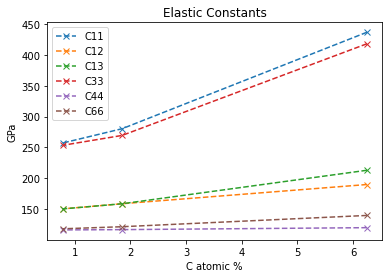

In [23]:
plt.plot([1/(a-1)*100 for a in atom_number_lst][:-1], [e[0,0] for e in elastic_matrix_lst][:-1], "x--", label="C11")
plt.plot([1/(a-1)*100 for a in atom_number_lst][:-1], [e[0,1] for e in elastic_matrix_lst][:-1], "x--", label="C12")
plt.plot([1/(a-1)*100 for a in atom_number_lst][:-1], [e[0,2] for e in elastic_matrix_lst][:-1], "x--", label="C13")
plt.plot([1/(a-1)*100 for a in atom_number_lst][:-1], [e[2,2] for e in elastic_matrix_lst][:-1], "x--", label="C33")
plt.plot([1/(a-1)*100 for a in atom_number_lst][:-1], [e[3,3] for e in elastic_matrix_lst][:-1], "x--", label="C44")
plt.plot([1/(a-1)*100 for a in atom_number_lst][:-1], [e[5,5] for e in elastic_matrix_lst][:-1], "x--", label="C66")
plt.legend()
plt.title("Elastic Constants")
plt.ylabel("GPa")
plt.xlabel("C atomic %")